In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

### 문제 1
호주 멜버른의 주택 가격 데이터셋 melb_data.csv으로 주택 가격을 예측하고,   
각종 평가지표를 사용하여 결정트리 모델을 평가하세요.

#### Data Description 

* `Rooms`: 방 개수

* `Price`: 가격(단위: $ 달러)

* `Type`: 주택 유형   
br - bedroom(s); h - house,cottage,villa, semi,terrace; u - unit, duplex; t - townhouse; dev site - development site; o res - other residential.

* `Distance`: Distance from CBD(Central Business District : 도심 지역)

* `Bedroom2` : Scraped # of Bedrooms (from different source) (주요 침실 개수)

* `Bathroom`: Number of Bathrooms

* `Car`: Number of carspots

* `Landsize`: Land Size

* `BuildingArea`: Building Size

* `CouncilArea`: Governing council for the area


우선 다음 코드들을 실행하여 melb_data변수명으로 데이터를 로드하고   
결정트리 분석에 필요한 컬럼만 남기고 결손값을 처리합니다.      
<span style='color:green'>(로컬 환경에 알맞게 file_path를 변경하세요)</span>
      
* feature 데이터 = [Rooms, Type, Distance, Bedroom2, Bathroom, Car, Landsize, BuildingArea, CouncilArea]   
* label 데이터 = Price      
   
(Price 값이 양적 자료이기 때문에 분류보단 회귀방식의 모델이 더 적합하지만, 결정트리를 사용하기 위해 편의상 Price값을 사분위수에 따라 범주형 자료로 변환하여 사용합니다.)

In [38]:
#(문제 아님)
file_path = '../data/melb_data.csv'
drop_columns=['Date','YearBuilt','Suburb','SellerG','Postcode','Address','Method','Lattitude','Longtitude','Propertycount']
melb_data = pd.read_csv(file_path).drop(columns=drop_columns,axis=1)
melb_data['CouncilArea'] = melb_data['CouncilArea'].fillna('Moreland')
melb_data['BuildingArea'] = melb_data['BuildingArea'].fillna(melb_data['BuildingArea'].mean())
melb_data['Car'] = melb_data['Car'].fillna(melb_data['Car'].median())

In [39]:
melb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rooms         13580 non-null  int64  
 1   Type          13580 non-null  object 
 2   Price         13580 non-null  float64
 3   Distance      13580 non-null  float64
 4   Bedroom2      13580 non-null  float64
 5   Bathroom      13580 non-null  float64
 6   Car           13580 non-null  float64
 7   Landsize      13580 non-null  float64
 8   BuildingArea  13580 non-null  float64
 9   CouncilArea   13580 non-null  object 
 10  Regionname    13580 non-null  object 
dtypes: float64(7), int64(1), object(3)
memory usage: 1.1+ MB


LabelEncoder를 사용하여 인코딩을 합니다.

In [40]:
#(문제 아님)
categorical_features = [ 'Type', 'CouncilArea','Regionname']
for col in categorical_features:
    le = LabelEncoder()
    melb_data[col] = le.fit_transform(melb_data[col])

### 1-1 (5점) - 전처리
label 데이터(target)로 Price 를 사용할 것입니다.   
그러나 양적 자료인 Price를 결정트리에 알맞게 범주형 자료로 변형하기 위해서 사분위수(quartile)와 2차세션 복습과제 때 학습했던 Tukey Fences 개념을 활용할 것입니다.   
아래 규칙과 같이 Price값을 바꾸세요.
   
   <span style='color:red'>[ 규칙 ]</span>
* 0 이상, Q1 미만 : '0' 
* Q1 이상, Q2 미만 : '1' 
* Q2 이상, Q3 미만 : '2' 
* Q3 이상 : '3' 
      
다음은 커스텀 함수 price_to_level()입니다. 위의 규칙에 맞게 빈칸을 알맞게 채우세요.   
   (문제에 적힌 대로 함수를 작성하지 않아도 됩니다. 아래 함수 출력 결과(0 1 2 3)가 일치하기만 하면 됩니다.)

In [ ]:
def price_to_level(prices): # prices : pd.Series객체로 전달해주세요
    # 문제) 사분위수(Q1,Q2,Q3) 구하기
    
    # 문제) 위의 규칙에 맞게 Price값에 따라 레벨로 변환하도록 코드를 작성하세요
    p_levels = []
    
    # Price_Level 데이터를 반환하세요.
    return p_levels    

# price_to_level() 커스텀 함수를 사용하여 Price컬럼값을 변경합니다.
melb_data['Price'] = price_to_level(melb_data['Price'])
# 문제) Price 컬럼명을 PriceLevel로 변경하세요. (힌트: pandas의 rename() 사용)


In [41]:
# 답)

def price_to_level(prices): # prices : pd.Series객체로 전달해주세요
    # 사분위수와 LF, UF
    Q1,Q2,Q3 = np.percentile(prices,[25,50,75])
    # 문제) 위의 규칙에 맞게 Price값에 따라 레벨로 변환하도록 코드를 작성하세요
    intervals = [(0,Q1),(Q1,Q2),(Q2,Q3),(Q3,prices.max()+1)]
    p_levels = []
    for p in prices:
        for i,interval in enumerate(intervals):
            if interval[0] <= p < interval[1]:
                p_levels.append(f'{i}')
    # Price_Level 데이터를 반환하세요.
    return p_levels    

# price_to_level() 커스텀 함수를 사용하여 Price컬럼값을 변경합니다.
melb_data['Price'] = price_to_level(melb_data['Price'])
# 문제) Price 컬럼명을 PriceLevel로 변경하세요. (힌트: pandas의 rename() 사용)
melb_data = melb_data.rename(columns={'Price':'PriceLevel'})


아래 코드를 실행하여 데이터 변환이 제대로 이루어졌는지 확인하세요.

In [42]:
#(문제아님)
### 간단하게 price_to_level() 커스텀 함수를 확인하세요 ###
print(melb_data.loc[8,'PriceLevel'],melb_data.loc[3,'PriceLevel'],
      melb_data.loc[1,'PriceLevel'],melb_data.loc[0,'PriceLevel'])
### 출력 결과가 0 1 2 3 이면, 커스텀 함수를 올바르게 작성한 것입니다. ###

0 1 2 3


### 1-2 (5점) - 정확도
melb_data 를 train_test_split() 함수로 학습/테스트용 데이터로 분리하고, 간단하게 DecisionTreeClassifier 를 사용하여 모델을 학습하고 PriceLevel을 예측해보세요. 그리고 예측 결과의 정확도(accuracy)를 평가해서 소수점 5번째 자리에서 반올림하여 출력해보세요.   
<span style='color:green'>(DecisionTreeClassfier 생성자 함수와 train_test_split의 random_state 파라미터값은 모두 10을 전달해주세요, test_size는 0.25로 설정해주세요.)</span>
* features 데이터 : PriceLevel을 제외한 나머지 컬럼   
* label 데이터 : PriceLevel 컬럼

In [43]:
# features 변수명에 해당 데이터를, label 변수명에 해당 데이터를 저장하고,
# train_test_split()으로 데이터를 분리하세요.


# 결정트리 객체를 생성하고 학습, 예측을 수행하세요. (예측값은 'pred' 변수명으로 저장하세요.)


# 예측 결과를 정확도로 평가하고 평가 결과를 위의 조건대로 반올림하여 출력하세요


In [44]:
# 답)

# features 변수명에 해당 데이터를, label 변수명에 해당 데이터를 저장하고,
# train_test_split()으로 데이터를 분리하세요.
features = melb_data.drop('PriceLevel',axis=1)
label = melb_data['PriceLevel']
X_train,X_test,y_train,y_test = train_test_split(features,label,test_size=0.25,random_state=10)

# 결정트리 객체를 생성하고 학습, 예측을 수행하세요. (예측값은 'pred' 변수명으로 저장하세요.)
dt_clf = DecisionTreeClassifier(random_state=10)
dt_clf.fit(X_train,y_train)
pred = dt_clf.predict(X_test)

# 예측 결과를 정확도로 평가하고 평가 결과를 위의 조건대로 반올림하여 출력하세요
np.round(accuracy_score(y_test,pred),4)


0.6236

### 1-3 (40점) - 정밀도와 재현율
위의 예측값(pred)과 실제값(y_test)을 토대로 confusion matrix를 구현해보세요.   (다중 분류일 때의 confusion matrix를 학습해봅시다)   
다음과 같은 모양으로 DataFrame객체를 생성해서 출력해보세요.   
   (개수는 해당 경우의 수를 의미)
|          | 0 | 1 | 2 | 3 |
|----------|----------|----------|----------|----------|
| 0 | 개수 | 개수 |개수  |개수  |
| 1 | 개수 | 개수 | 개수 | 개수 |
| 2 | 개수 | 개수 | 개수 | 개수 |
| 3 | 개수 | 개수 | 개수 | 개수 |

**a)**
sklearn.metrics의 confusion_matrix() 함수로 생성한 오차행렬을 cm 변수에 저장하고,
이를 DataFrame객체로 변환해 위의 예시처럼 예쁘게 출력하세요.   
**(5점)**

In [ ]:
classes = ['0', '1', '2', '3'] # 레이블 클래스
# 변수 cm에 confusion_matrix를 저장하세요

# pandas DataFrame으로 변환하여 예쁘게 출력하세요


In [45]:
# 답)

classes = ['0', '1', '2', '3'] # 레이블 클래스
# 변수 cm에 confusion_matrix를 저장하세요
cm = (confusion_matrix(y_test,pred))
# pandas DataFrame으로 변환하여 예쁘게 출력하세요
pd.DataFrame(cm,index=classes,columns=classes)

,0,1,2,3
0,649,183,22,4
1,175,434,186,45
2,32,186,450,196
3,8,31,210,584


####  직접 재현율(recall)과 정밀도(precision)를 구해서 확인해보세요
힌트: 다중분류의 confusion matrix를 학습하고 macro-averaging과 micro-averaging을 학습하세요.

**b)** macro-averaging(macro-mean) 방식을 사용하여 macro_precision과 macro_recall 값을 구하고 출력하세요.   
(반복문을 사용하여 해결하세요, 변수명도 각각 macro_precision과 macro_recall을 사용하세요.)      
**(13점)**

In [46]:
# 답)
macro_precisions = []
macro_recalls = []
TPS = []
FPS = []
FNS = []
for i in range(cm.shape[0]):
    TP = cm[i][i]
    FP = 0
    FN = 0
    for j in range(cm.shape[0]):
        if i == j :
            continue
        FP += cm[j][i]
        FN += cm[i][j]
    macro_precisions.append(TP/(TP+FP))
    macro_recalls.append(TP/(TP+FN))
    TPS.append(TP)
    FPS.append(FP)
    FNS.append(FN)
macro_precision = np.mean(macro_precisions)
print('macro_precision:',macro_precision)
macro_recall = np.mean(macro_recalls)
print('macro_recall:',macro_recall) 

macro_precision: 0.623609372215409
macro_recall: 0.6237476721457814


**c)** micro-averaging 방식을 사용하여 micro_precision과 micro_recall 값을 구하고 출력하세요.   
(변수명도 각각 micro_precision과 micro_recall을 사용하세요.)   
(힌트: 위의 반복문에서 미리 TP,FP,FN들을 저장하면 여기선 계산만 하면 됩니다.)   
**(13점)**

In [47]:
# 답)
micro_precision = sum(TPS)/(sum(TPS)+sum(FPS))
micro_recall = sum(TPS)/(sum(TPS)+sum(FNS))
print('micro_precision:',micro_precision)
print('micro_recall:',micro_recall)

micro_precision: 0.6235640648011782
micro_recall: 0.6235640648011782


**d)** sklearn.metrics의 classification_report() 함수를 사용하여 구한 평가지표 결과를 clf_report 변수에 저장하세요  
그리고 해당 변수를 DataFrame 객체로 변환하여 출력하세요.   
(힌트 : classification_report()함수의 파라미터들을 학습하고 데이터프레임 객체로 쉽게 변환하는 방법을 찾아보세요)   
**(4점)**

In [ ]:
# classification_report를 변수에 저장하고 DataFrame으로 변환하여 출력하세요.


In [48]:
# 답)
clf_report = classification_report(y_test,pred,labels=classes,target_names=classes,output_dict=True)
clf_report_df = pd.DataFrame(clf_report)
clf_report_df

,0,1,2,3,accuracy,macro avg,weighted avg
precision,0.751157,0.520384,0.518433,0.704463,0.623564,0.623609,0.623375
recall,0.756410,0.516667,0.520833,0.701080,0.623564,0.623748,0.623564
f1-score,0.753775,0.518519,0.519630,0.702768,0.623564,0.623673,0.623464
support,858.000000,840.000000,864.000000,833.000000,0.623564,3395.000000,3395.000000


**e)** 위에서 직접 구한 macro_precision, macro_recall, micro_precision, micro_recall값이 clf_report의 내용과 같은지 소수점 4번째 자리까지 비교하여 출력하세요.
* 출력용 코드 예시   
<code>print('[Macro_P] my_score:{:.4f}, report_score:{:.4f}'.format(macro_precision,report_mac_precision))</code>   
<code>print('[Macro_R] my_score:{:.4f}, report_score:{:.4f}'.format(macro_recall,report_mac_recall))</code>   
<code>print('[Micro_P] my_score:{:.4f}, report_score:{:.4f}'.format(micro_precision,report_mic_precision))</code>   
<code>print('[Micro_R] my_score:{:.4f}, report_score:{:.4f}'.format(micro_recall,report_mic_recall))</code>
      
(힌트: classification_report를 출력해보면 micro averaging한 데이터가 없다! 그러나 micro averaging의 수식을 잘 살펴보면 어떤 평가지표와 의미가 같다는 사실을 알 수 있다.)   
**(5점)**

In [49]:
# 위의 출력 코드 예시를 활용해서 각 평가 결과값들을 비교하여 출력하세요


In [50]:
# 답)
report_mac_precision,report_mac_recall = clf_report_df['macro avg'][[0,1]]
report_mic_precision,report_mic_recall = clf_report_df['accuracy'][[0,1]]
print('[Macro_P] my_score:{:.4f}, report_score:{:.4f}'.format(macro_precision,report_mac_precision))
print('[Macro_R] my_score:{:.4f}, report_score:{:.4f}'.format(macro_recall,report_mac_recall))
print('[Micro_P] my_score:{:.4f}, report_score:{:.4f}'.format(micro_precision,report_mic_precision))
print('[Micro_R] my_score:{:.4f}, report_score:{:.4f}'.format(micro_recall,report_mic_recall))

[Macro_P] my_score:0.6236, report_score:0.6236
[Macro_R] my_score:0.6237, report_score:0.6237
[Micro_P] my_score:0.6236, report_score:0.6236
[Micro_R] my_score:0.6236, report_score:0.6236


### 문제2 (50점)
위스콘신 유방암 데이터 세트는 종양의 크기, 모양 등의 다양한 속성 값을 기반으로 해당 종양이 악성인지 양성인지를 분류한 데이터 세트입니다. 종양의 양성 여부는 class 컬럼에서 확인할 수 있으며, 양성은 2, 악성은 4로 표시되어 있습니다.  

아래의 코드를 실행해주세요.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import roc_auc_score

2-1. *breast_cancer* 데이터셋을 데이터프레임으로 불러온 후 df 변수에 저장해주세요. 상위 5개의 행을 확인할 수 있도록 출력해주세요.  **(3점)**  
(데이터셋의 첫 번째, 두 번째 열을 삭제한 후, 아래의 사진과 같은 결과가 나오도록 출력해주세요.)
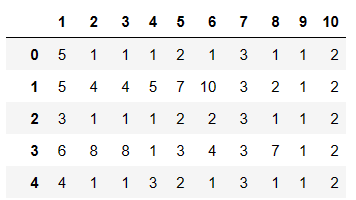

In [2]:
# 답)
df = pd.read_csv('breast_cancer.csv')
df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10
0,0,1000025,5,1,1,1,2,1,3,1,1,2
1,1,1002945,5,4,4,5,7,10,3,2,1,2
2,2,1015425,3,1,1,1,2,2,3,1,1,2
3,3,1016277,6,8,8,1,3,4,3,7,1,2
4,4,1017023,4,1,1,3,2,1,3,1,1,2


In [ ]:
# df 데이터셋의 첫 번째, 두 번째 열을 삭제해주세요.


In [3]:
# 답)
# df 데이터셋의 첫 번째, 두 번째 열을 삭제해주세요.
df.drop(df.columns[0:2], axis = 1, inplace = True)

2-2. 아래의 colums_name 변수를 활용하여 0~10까지의 숫자로 되어 있는 컬럼명을 변경해주세요. **(3점)**  
(각각의 컬럼과 columns_name 변수 안의 컬럼명의 순서는 동일합니다. 아래의 사진과 같은 데이터셋의 형태를 띌 수 있도록 컬럼명을 변경해주세요. 아래의 columns_name 변수를 복사해서 코드를 작성해주세요.)

columns_name = ['clump', 'cell_size', 'cell_shape', 'adhesion', 'epithlial', 'bare_nuclei', 
                'chromatin', 'normal_nucleoli', 'mitoses', 'class']
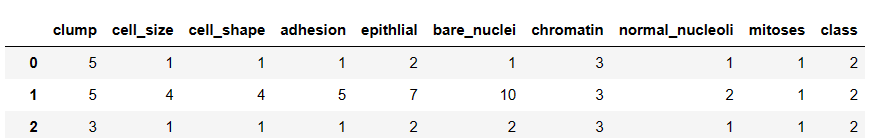

In [4]:
# 답)
columns_name = ['clump', 'cell_size', 'cell_shape', 'adhesion', 'epithlial', 'bare_nuclei', 
                'chromatin', 'normal_nucleoli', 'mitoses', 'class']

In [5]:
# 답)
df.columns = columns_name

2-3. 다음의 설명에 따라 전처리를 진행해주세요. **(6점)**

In [ ]:
# info를 활용하여 데이터타입을 확인해주세요.


In [6]:
# 답)
# info를 활용하여 데이터타입을 확인해주세요.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   clump            699 non-null    int64 
 1   cell_size        699 non-null    int64 
 2   cell_shape       699 non-null    int64 
 3   adhesion         699 non-null    int64 
 4   epithlial        699 non-null    int64 
 5   bare_nuclei      699 non-null    object
 6   chromatin        699 non-null    int64 
 7   normal_nucleoli  699 non-null    int64 
 8   mitoses          699 non-null    int64 
 9   class            699 non-null    int64 
dtypes: int64(9), object(1)
memory usage: 54.7+ KB


In [ ]:
# df 데이터 중 bare_nuclei 컬럼의 값 분포를 확인해주세요. (value_counts 활용)


In [7]:
# 답)
# df 데이터 중 bare_nuclei 컬럼의 값 분포를 확인해주세요. (value_counts 활용)
df['bare_nuclei'].value_counts()

1     402
10    132
2      30
5      30
3      28
8      21
4      19
?      16
9       9
7       8
6       4
Name: bare_nuclei, dtype: int64

In [ ]:
# 'bare_nuclei'컬럼에 있는 값 중'?'를 'bare_nuclei' 컬럼의 최빈값으로 바꿔주세요.


In [8]:
# 답)
# 'bare_nuclei'컬럼에 있는 값 중'?'를 'bare_nuclei' 컬럼의 최빈값으로 바꿔주세요.
df['bare_nuclei'].replace('?', df['bare_nuclei'].mode()[0], inplace=True)

In [ ]:
# 'bare_nuclei'컬럼의 데이터 타입을 숫자형(int)으로 바꿔주세요.


In [9]:
# 답)
# 'bare_nuclei'컬럼의 데이터 타입을 숫자형(int)으로 바꿔주세요.
df['bare_nuclei'] = df['bare_nuclei'].astype('int')

In [ ]:
# 양성은 2, 악성은 4로 표시되어 있는 df['class'] 값 중 2(양성)는 숫자 0으로, 4(음성)는 숫자 1로 바꿔주세요.


In [10]:
# 답)
# 양성은 2, 악성은 4로 표시되어 있는 df['class'] 값 중 2(양성)는 숫자 0으로, 4(음성)는 숫자 1로 바꿔주세요.
df['class'] = df['class'].replace(2, 0)
df['class'] = df['class'].replace(4, 1)

2-4. 아래의 설명에 따라 데이터를 분리해주세요. **(6점)**

In [ ]:
# 피처 데이터 세트 x, 레이블 데이터 세트 y를 추출해주세요. (레이블 데이터는 class컬럼에 담겨있습니다.)



In [11]:
# 답)
# 피처 데이터 세트 x, 레이블 데이터 세트 y를 추출해주세요. (레이블 데이터는 class컬럼에 담겨있습니다.)
x = df.drop(['class'], axis = 1)
y = df['class']

In [ ]:
# 이진 분류 로지스틱 회귀분석이 가능하도록 y의 데이터 타입을 변경해주세요. (데이터타입만 변경해주세요.)


In [12]:
# 답)
# 이진 분류 로지스틱 회귀분석이 가능하도록 y의 데이터 타입을 변경해주세요. (데이터타입만 변경해주세요.)
y = y.astype('int')

2-5. StandardScaler를 활용하여 개별 피처의 평균이 0이고, 분산이 1인 값으로 변환해주세요. 또한, 변환된 데이터 세트를 DataFrame으로 변환해 data_df라는 변수에 저장해주세요. data_df 데이터프레임의 컬럼명은 아래의 columns_name2 변수를 그대로 활용하여 설정해주세요. **(6점)**  
columns_name2 = ['clump', 'cell_size', 'cell_shape', 'adhesion', 'epithlial', 'bare_nuclei', 
                'chromatin', 'normal_nucleoli', 'mitoses']

(columns_name2 변수에 담겨있는 컬럼명의 순서와 데이터프레임 각 열의 순서는 동일하기 때문에 columns_name2 변수를 수정할 필요는 없습니다.)

In [ ]:
# StandardScaler 객체 생성

# StandardScaler로 데이터 세트 변환. fit()과 transform() 호출



In [13]:
#답)
# StandardScaler 객체 생성
scaler = StandardScaler()
# StandardScaler로 데이터 세트 변환. fit()과 transform() 호출
scaler.fit(x)
x = scaler.transform(x)

In [ ]:
# columns_name2 변수를 생성해주세요.


# data_df 변수에 변환된 데이터프레임을 저장해주세요.

# data_df 데이터프레임의 하위 5개 행을 출력해주세요.


In [14]:
#답)
# columns_name2 변수를 생성해주세요.
columns_name2 = ['clump', 'cell_size', 'cell_shape', 
                 'adhesion', 'epithlial', 'bare_nuclei', 'chromatin', 'normal_nucleoli', 'mitoses']
# data_df 변수에 변환된 데이터프레임을 저장해주세요.
x = pd.DataFrame(x, columns = columns_name2)
# data_df 데이터프레임의 하위 5개 행을 출력해주세요.
x.tail()

,clump,cell_size,cell_shape,adhesion,epithlial,bare_nuclei,chromatin,normal_nucleoli,mitoses
694,-0.503866,-0.699995,-0.743299,-0.633247,-0.097628,-0.410685,-1.000471,-0.611825,-0.343912
695,-0.859266,-0.699995,-0.743299,-0.633247,-0.549561,-0.686979,-1.000471,-0.611825,-0.343912
696,0.206936,2.251526,2.287222,0.067687,1.710106,-0.134392,1.872361,2.337594,0.239570
697,-0.148465,1.595632,0.940324,0.418154,-0.097628,0.141902,2.693171,1.026741,-0.343912
698,-0.148465,1.595632,1.613773,0.768621,0.354305,0.418196,2.693171,0.371315,-0.343912


2-6. 아래의 설명에 따라 데이터를 분리해주세요. **(3점)**

In [ ]:
# 학습데이터와 테스트 데이터를 나눠주세요. (random_state는 11로 설정해주세요.)


In [15]:
#답)
# 학습데이터와 테스트 데이터를 나눠주세요. (random_state는 11로 설정해주세요.)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=11)

In [ ]:
# 분리한 데이터의 형태를 출력해주세요. (shape 활용)


In [16]:
#답)
# 분리한 데이터의 형태를 출력해주세요. (shape 활용)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(559, 9) (140, 9) (559,) (140,)


2-7. 로지스틱 회귀로 학습, 예측 및 평가 수행 **(13점)**

In [ ]:
# LogisticRegression 객체를 생성해주세요. 해당 객체의 파라미터 중 solver는 'liblinear'로 설정하고 random_state는 11로 설정해주세요.

# LogisticRegression 객체를 활용한 학습

# LogisticRegression 객체를 활용한 예측 (LogisticRegression 객체의 predict 메서드 활용)


In [17]:
#답)
# LogisticRegression 객체를 생성해주세요. 해당 객체의 파라미터 중 solver는 'liblinear'로 설정하고 random_state는 11로 설정해주세요.
lr_clf = LogisticRegression(solver='liblinear', random_state=11)
# LogisticRegression 객체를 활용한 학습
lr_clf.fit(x_train, y_train)
# LogisticRegression 객체를 활용한 예측 (LogisticRegression 객체의 predict 메서드 활용)
lr_pred = lr_clf.predict(x_test)


In [ ]:
# pred_proba 변수를 생성하고 이 변수에 클래스별 확률값을 저장하세요. (LogisticRegression 객체의 predict_proba() 메서드를 활용)

# pred_proba_class1 변수를 만들고 이 변수에 레이블 값이 1일때의 예측 확률을 저장해주세요.(LogisticRegression 객체의 predict_proba() 메서드를 활용)



In [18]:
#답)
# pred_proba 변수를 생성하고 이 변수에 클래스별 확률값을 저장하세요. (LogisticRegression 객체의 predict_proba() 메서드를 활용)
pred_proba = lr_clf.predict_proba(x_test)
# pred_proba_class1 변수를 만들고 이 변수에 레이블 값이 1일때의 예측 확률을 저장해주세요.(LogisticRegression 객체의 predict_proba() 메서드를 활용)
pred_proba_class1 = lr_clf.predict_proba(x_test)[:,1]

In [ ]:
#roc_curve API를 이용해 예측 모델의 FPR, TPR, 임계값을 구해주세요.


# 반환된 임곗값 배열에서 샘플로 데이터를 추출하되, 임곗값을 4 Step으로 추출해주세요. np.arange는 1부터 시작할 수 있도록 설정해주세요.


# '샘플 추출을 위한 임곗값 배열의 index'과 '샘플 index로 추출한 임곗값'을 출력해주세요. 각각의 값은 소수점 넷째 자리에서 반올림하여 출력해주세요.



# 4 Step 단위로 추출된 임곗값에 따른 FPR, TPR 값을 출력해주세요. 각각의 값은 소수점 넷째 자리에서 반올림하여 출력해주세요.




In [24]:
#답)
#roc_curve API를 이용해 예측 모델의 FPR, TPR, 임계값을 구해주세요.
fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)

# 반환된 임곗값 배열에서 샘플로 데이터를 추출하되, 임곗값을 4 Step으로 추출해주세요. np.arange는 1부터 시작할 수 있도록 설정해주세요.
thr_index = np.arange(1, thresholds.shape[0], 4)

# '샘플 추출을 위한 임곗값 배열의 index'과 '샘플 index로 추출한 임곗값'을 출력해주세요. 각각의 값은 소수점 넷째 자리에서 반올림하여 출력해주세요.
print('샘플 추출을 위한 임곗값 배열의 index: ', thr_index)
print('샘플 index로 추출한 임곗값: ', np.round(thresholds[thr_index], 3))

# 4 Step 단위로 추출된 임곗값에 따른 FPR, TPR 값을 출력해주세요. 각각의 값은 소수점 넷째 자리에서 반올림하여 출력해주세요.
print('샘플 임곗값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR: ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index:  [ 1  5  9 13 17 21 25]
샘플 index로 추출한 임곗값:  [1.    0.642 0.178 0.015 0.007 0.004 0.003]
샘플 임곗값별 FPR:  [0.    0.024 0.048 0.262 0.524 0.714 0.881]
샘플 임곗값별 TPR:  [0.018 0.911 0.964 1.    1.    1.    1.   ]


In [ ]:
# roc_auc_score API를 활용하여 roc auc 값을 출력해주세요.(소수점 넷째 자리에서 반올림하여 출력)



In [25]:
#답)
# roc_auc_score API를 활용하여 roc auc 값을 출력해주세요.(소수점 넷째 자리에서 반올림하여 출력)
roc_score = roc_auc_score(y_test, pred_proba_class1)
print('ROC AUC 값: ', np.round(roc_score,3))

ROC AUC 값:  0.994


2-8. 이전 문제에서 LogisticRegression 객체의 solver 파라미터를 'lbfgs'로만 설정했던 것과 달리 이번에는 서로 다른 solver 값으로 LogisticRegression을 학습해보고 얻은 성능 평가를 비교해보려고 합니다. 아래의 코드를 완성해주세요.   **(10점)**  
(아래의 사진과 같은 형태로 출력될 수 있도록 코드를 작성해주세요.)

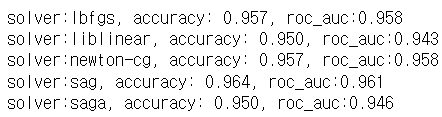  
(성능 평가 결과값은 사진 속 값과 다르게 나올 수 있습니다.)

In [ ]:
solver_list = ['lbfgs','liblinear','newton-cg', 'sag', 'saga']

# solver_list에 담겨있는 각각의 solver 값을 한 번씩 적용하여 LogisticRegression을 학습하고 성능을 평가해주세요. (힌트: for 구문 활용)
# 출력 결과에서 5가지 solver 값에 대한 성능 평과 결과를 각각 얻을 수 있도록 for 구문을 활용하여 코드를 완성해주세요.
# LogisticRegression 객체의 파라미터는 solver, max_iter, random_state만 설정해주세요. max_iter는 300으로 설정하고 random_state는 11로 설정해주세요.

#for구문 작성

    # 로지스틱 회귀 객체를 생성해주세요.
    
    # fit을 사용하여 학습해주세요.
    lr_clf.fit(x_train, y_train)
    # 예측
    lr_preds = lr_clf.predict(x_test)
    # accuracy와 roc_auc 측정
    
    

In [22]:
#답)
solver_list = ['lbfgs','liblinear','newton-cg', 'sag', 'saga']

# solver_list에 담겨있는 각각의 solver 값을 한 번씩 적용하여 LogisticRegression을 학습하고 성능을 평가해주세요. (힌트: for 구문 활용)
# 출력 결과에서 5가지 solver 값에 대한 성능 평과 결과를 각각 얻을 수 있도록 for 구문을 활용하여 코드를 완성해주세요.
# LogisticRegression 객체의 파라미터는 solver, max_iter, random_state만 설정해주세요. max_iter는 300으로 설정하고 random_state는 11로 설정해주세요.

#for구문 작성
for i in solver_list:
    # 로지스틱 회귀 객체를 생성해주세요.
    lr_clf = LogisticRegression(solver = i, max_iter=300, random_state=11)
    # fit을 사용하여 학습해주세요.
    lr_clf.fit(x_train, y_train)
    # 예측
    lr_preds = lr_clf.predict(x_test)
    # accuracy와 roc_auc 측정
    print('solver:{0}, accuracy: {1:.3f}, roc_auc:{2:.3f}'.format(i, accuracy_score(y_test, lr_preds), 
                                                                  roc_auc_score(y_test, lr_preds)))

solver:lbfgs, accuracy: 0.964, roc_auc:0.961
solver:liblinear, accuracy: 0.964, roc_auc:0.961
solver:newton-cg, accuracy: 0.964, roc_auc:0.961
solver:sag, accuracy: 0.964, roc_auc:0.961
solver:saga, accuracy: 0.964, roc_auc:0.961
